### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [3]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from model import *

In [5]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.2.4-tf
TensorFlow version: 1.14.0


In [6]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

In [7]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [8]:
# Loading full images of desired resolution:
img_train = h5f['DRISHTI-GS/512 px/images']
cup_train = h5f['DRISHTI-GS/512 px/cup']
disc_train = h5f['DRISHTI-GS/512 px/disc']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

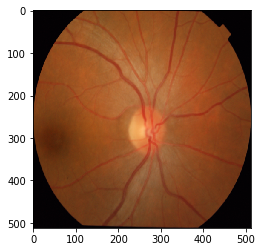

(50, 512, 512, 3)


(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc_locations": shape (50, 4), type "<i8">)

In [9]:
plt.imshow(img_train[45])
plt.show()
print(img_train.shape)
img_train, cup_train, disc_train, disc_locations

### Train images

In [10]:
green_channel_train = get_color_channel(1, img_train)
len(green_channel_train)

50

### Test images

In [11]:
green_channel_test = get_color_channel(1, img_test)
len(green_channel_test)

51

#### Generator of augmented data:

Testing the data generator and generator for augmented data:

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


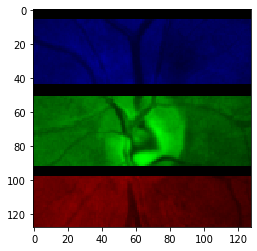

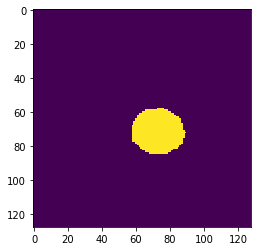

In [12]:
gen = data_generator(green_channel_train, cup_train, disc_locations, 128, 'train', batch_size=1)
batch = next(gen)

plt.imshow(np.squeeze(batch[0][0]))
plt.show()
plt.imshow(np.squeeze(batch[1][0]))

In [13]:
X_valid, Y_valid = next(data_generator(green_channel_test, cup_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))
len(X_valid), len(Y_valid)

(51, 51)

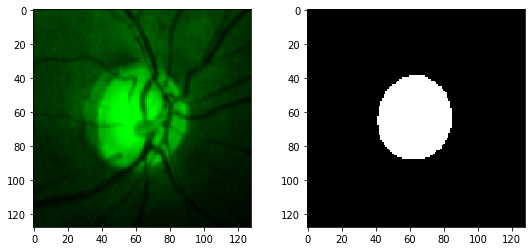

In [14]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.squeeze(X_valid[10]), cmap=plt.cm.Greys_r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.squeeze(Y_valid[10]), cmap=plt.cm.Greys_r)
plt.show()

### Training and test cup

In [ ]:
train(green_channel_train, cup_train, disc_locations, 'cup_green', model, 1000)

### Visual check

image #0


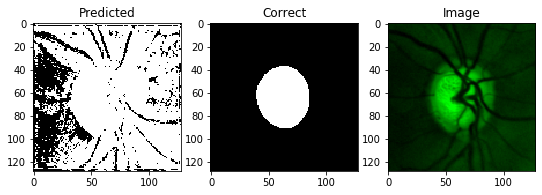

IOU: 0.15227654576301575
Dice: 0.26430555555555557
0.15227655
0.26430555555555557


In [17]:
pred_iou, pred_dice, pred_disc = predict(green_channel_test, X_valid, Y_valid, model)

print(np.mean(pred_iou))
print(np.mean(pred_dice))

Acquiring scores for the validation set:

### Training and Test disc

In [52]:
X_valid, Z_valid = next(data_generator(green_channel_test, disc_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

In [ ]:
num = 1
for i in range(num):
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.squeeze(X_valid[i]), cmap=plt.cm.Greys_r)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.squeeze(Z_valid[i]), cmap=plt.cm.Greys_r)
    plt.show()
    print('=========================')

In [53]:
train(green_channel_train, disc_train, disc_locations, 'disc_green', model, 1000)

Epoch 1/1
99/99 [==============================] - 47s 479ms/step - loss: 0.9989 - mean_IOU_gpu: 4.8342e-05 - dice_metric: 9.6644e-05 - val_loss: 0.9581 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00


image #0


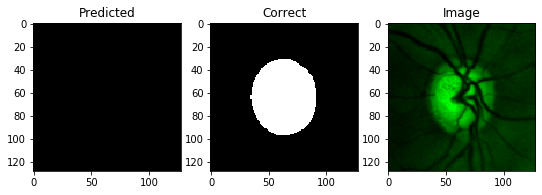

IOU: 0.0
Dice: 0.0
0.0
0.0


In [54]:
pred_iou, pred_dice, pred_disc = predict(green_channel_test, X_valid, Z_valid, model)

print(np.mean(pred_iou))
print(np.mean(pred_dice))

### Cálculo do CDR

In [ ]:
cdrs = calculate_cdr(pred_cup, pred_disc)cdrs = calculate_cdr(pred_cup, pred_disc)
areas = calculate_area(pred_cup, pred_disc)
d = {'cdr': cdrs, 'area': areas}
df = pd.DataFrame(data=d)
df